### Data Preprocessing

In [1]:
import pandas as pd 
import os
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from PIL import Image
#from imutils import paths
import random
import pickle
import cv2
import datetime
from pprint import pprint
import librosa
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.metrics import *
import keras
from keras.utils import np_utils
from keras.regularizers import *
from keras.initializers import glorot_uniform
import keras.backend as K
K.clear_session()
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras.callbacks import *

In [2]:
benign=pd.read_csv('5.benign.csv')
g_c=pd.read_csv('5.gafgyt.combo.csv')
g_j=pd.read_csv('5.gafgyt.junk.csv')
g_s=pd.read_csv('5.gafgyt.scan.csv')
g_t=pd.read_csv('5.gafgyt.tcp.csv')
g_u=pd.read_csv('5.gafgyt.udp.csv')
m_a=pd.read_csv('5.mirai.ack.csv')
m_sc=pd.read_csv('5.mirai.scan.csv')
m_sy=pd.read_csv('5.mirai.syn.csv')
m_u=pd.read_csv('5.mirai.udp.csv')
m_u_p=pd.read_csv('5.mirai.udpplain.csv')

In [3]:
benign=benign.sample(frac=0.25,replace=False)
g_c=g_c.sample(frac=0.25,replace=False)
g_j=g_j.sample(frac=0.5,replace=False)
g_s=g_s.sample(frac=0.5,replace=False)
g_t=g_t.sample(frac=0.15,replace=False)
g_u=g_u.sample(frac=0.15,replace=False)
m_a=m_a.sample(frac=0.25,replace=False)
m_sc=m_sc.sample(frac=0.15,replace=False)
m_sy=m_sy.sample(frac=0.25,replace=False)
m_u=m_u.sample(frac=0.1,replace=False)
m_u_p=m_u_p.sample(frac=0.27,replace=False)

benign['type']='benign'
m_u['type']='mirai_udp'
g_c['type']='gafgyt_combo'
g_j['type']='gafgyt_junk'
g_s['type']='gafgyt_scan'
g_t['type']='gafgyt_tcp'
g_u['type']='gafgyt_udp'
m_a['type']='mirai_ack'
m_sc['type']='mirai_scan'
m_sy['type']='mirai_syn'
m_u_p['type']='mirai_udpplain'

data=pd.concat([benign,m_u,g_c,g_j,g_s,g_t,g_u,m_a,m_sc,m_sy,m_u_p],
               axis=0, sort=False, ignore_index=True)

In [4]:
data.groupby('type')['type'].count()

type
benign             7591
gafgyt_combo       4641
gafgyt_junk        9318
gafgyt_scan       11638
gafgyt_tcp         8384
gafgyt_udp         8669
mirai_ack          6186
mirai_scan         4913
mirai_syn          6546
mirai_udp          2539
mirai_udpplain     6246
Name: type, dtype: int64

<AxesSubplot:title={'center':'Class Distribution'}, ylabel='None'>

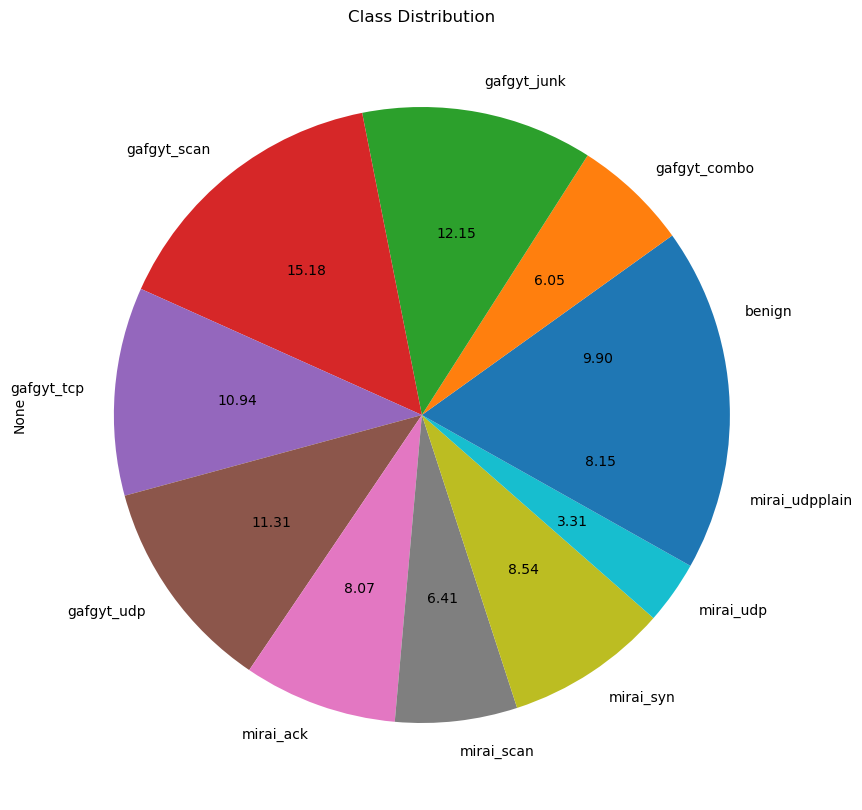

In [5]:
from matplotlib import pyplot as plt
plt.title("Class Distribution")
data.groupby("type").size().plot(kind='pie', autopct='%.2f', figsize=(20,10))

In [45]:
data.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
51276,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000,0.000000
40935,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000,0.000000
26736,22.456933,74.085887,2.053920e+00,48.738744,74.120836,2.886216,173.575432,74.183042,8.988332e+00,1195.011380,...,0.000000,0.000000e+00,0.000000e+00,2.898498,74.000000,9.536743e-07,74.000000,9.094947e-13,0.000000,0.000000
49179,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000,0.000000
1813,2.999879,90.000000,1.820000e-12,2.999928,90.000000,0.000000,2.999976,90.000000,8.910000e-11,3.316363,...,0.000006,-8.920000e-15,-5.000000e-09,4.112107,88.779343,5.927031e+00,107.213239,3.513029e+01,-0.132087,-0.049417


In [7]:
sampler=np.random.permutation(len(data))
data=data.take(sampler)
data.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,type
2228,1.000000,60.000003,0.000078,1.000090,60.002703,0.081081,1.093268,62.558944,70.220127,3.707847,...,-4.080000e-31,-6.350000e-19,5.709685,60.0,0.000001,84.852814,1.640000e-12,1.150000e-29,1.040000e-17,benign
10280,152.732884,74.334241,81.408939,253.512984,74.517632,125.965061,774.521678,74.439241,106.494271,3235.764978,...,0.000000e+00,0.000000e+00,1.000000,74.0,0.000000,74.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_combo
49359,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.000000e+00,1.000000,60.0,0.000000,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_udp
39150,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.000000e+00,1.000000,60.0,0.000000,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_tcp
58430,71.420360,60.001376,0.692434,95.675909,60.323544,163.398002,257.756430,110.783232,23109.549882,2528.150521,...,0.000000e+00,0.000000e+00,1.000000,60.0,0.000000,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,mirai_ack


In [8]:
sampler=np.random.permutation(len(data))
data=data.take(sampler)
data.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,type
51276,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000,0.000000,gafgyt_udp
40935,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000,0.000000,gafgyt_tcp
26736,22.456933,74.085887,2.053920e+00,48.738744,74.120836,2.886216,173.575432,74.183042,8.988332e+00,1195.011380,...,0.000000e+00,0.000000e+00,2.898498,74.000000,9.536743e-07,74.000000,9.094947e-13,0.000000,0.000000,gafgyt_scan
49179,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000,0.000000,gafgyt_udp
1813,2.999879,90.000000,1.820000e-12,2.999928,90.000000,0.000000,2.999976,90.000000,8.910000e-11,3.316363,...,-8.920000e-15,-5.000000e-09,4.112107,88.779343,5.927031e+00,107.213239,3.513029e+01,-0.132087,-0.049417,benign


In [9]:

labels_full=pd.get_dummies(data['type'], prefix='type')
labels_full.head()

,type_benign,type_gafgyt_combo,type_gafgyt_junk,type_gafgyt_scan,type_gafgyt_tcp,type_gafgyt_udp,type_mirai_ack,type_mirai_scan,type_mirai_syn,type_mirai_udp,type_mirai_udpplain
51276,0,0,0,0,0,1,0,0,0,0,0
40935,0,0,0,0,1,0,0,0,0,0,0
26736,0,0,0,1,0,0,0,0,0,0,0
49179,0,0,0,0,0,1,0,0,0,0,0
1813,1,0,0,0,0,0,0,0,0,0,0


In [10]:

data=data.drop(columns='type')
data.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
51276,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000,0.000000
40935,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000,0.000000
26736,22.456933,74.085887,2.053920e+00,48.738744,74.120836,2.886216,173.575432,74.183042,8.988332e+00,1195.011380,...,0.000000,0.000000e+00,0.000000e+00,2.898498,74.000000,9.536743e-07,74.000000,9.094947e-13,0.000000,0.000000
49179,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000,0.000000e+00,0.000000e+00,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000,0.000000
1813,2.999879,90.000000,1.820000e-12,2.999928,90.000000,0.000000,2.999976,90.000000,8.910000e-11,3.316363,...,0.000006,-8.920000e-15,-5.000000e-09,4.112107,88.779343,5.927031e+00,107.213239,3.513029e+01,-0.132087,-0.049417


In [11]:
class_labels = ['benign', 'mirai_udp', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan', 
                'gafgyt_tcp', 'gafgyt_udp', 'mirai_ack', 'mirai_scan', 'mirai_syn', 'mirai_udpplain']

In [12]:

def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/df[col].std()

data_st=data.copy()
for i in (data_st.iloc[:,:-1].columns):
    standardize (data_st,i)
data_st.head()


,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
51276,-1.053521,-0.525806,-0.498681,-1.029813,-0.548610,-0.514341,-0.987657,-0.576470,-0.530418,-1.007132,...,-0.101271,-0.098191,-0.070384,-0.184612,-0.404593,-0.129837,-0.418139,-0.100402,-0.093199,0.000000
40935,-1.053521,-0.525806,-0.498681,-1.029813,-0.548610,-0.514341,-0.987657,-0.576470,-0.530418,-1.007132,...,-0.101271,-0.098191,-0.070384,-0.184612,-0.404593,-0.129837,-0.418139,-0.100402,-0.093199,0.000000
26736,-0.726826,-0.403582,-0.498583,-0.573312,-0.420814,-0.514213,-0.401257,-0.442079,-0.530042,-0.434478,...,-0.101271,-0.098191,-0.070384,-0.182807,-0.312531,-0.129837,-0.328422,-0.100402,-0.093199,0.000000
49179,-1.053521,-0.525806,-0.498681,-1.029813,-0.548610,-0.514341,-0.987657,-0.576470,-0.530418,-1.007132,...,-0.101271,-0.098191,-0.070384,-0.184612,-0.404593,-0.129837,-0.418139,-0.100402,-0.093199,0.000000
1813,-1.023072,-0.265495,-0.498681,-1.010689,-0.277104,-0.514341,-0.980861,-0.292206,-0.530418,-1.006021,...,-0.101271,-0.098191,-0.070384,-0.181653,-0.215345,0.059126,-0.115579,-0.098358,-0.093237,-0.049417


In [13]:
train_data_st=data_st.values
train_data_st

array([[-1.0535212 , -0.52580607, -0.49868094, ..., -0.10040171,
        -0.09319935,  0.        ],
       [-1.0535212 , -0.52580607, -0.49868094, ..., -0.10040171,
        -0.09319935,  0.        ],
       [-0.72682592, -0.40358215, -0.49858324, ..., -0.10040171,
        -0.09319935,  0.        ],
       ...,
       [-1.02307148, -0.26549464, -0.49868094, ..., -0.09508507,
        -0.0932667 , -0.03566693],
       [-1.01594043, -0.38892393, -0.49680133, ..., -0.10040171,
        -0.09319935,  0.        ],
       [-1.0535212 , -0.52580607, -0.49868094, ..., -0.10040171,
        -0.09319935,  0.        ]])

In [14]:
labels=labels_full.values
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [15]:
import numpy as np

train_data_st = np.nan_to_num(train_data_st, nan=0.0)

if np.isnan(train_data_st).any() or not np.isfinite(train_data_st).all():
    print("NaN or infinite values still found in the training data after handling. Please check the data.")
else:
    print("No NaN or infinite values found in the training data after handling.")


No NaN or infinite values found in the training data after handling.


### Model Training

In [16]:

train_indices, test_indices = train_test_split(range(len(data)), test_size=0.25, random_state=42)

train_labels = labels[train_indices]


print("Shape of train_labels:", train_labels.shape)


Shape of train_labels: (57503, 11)


In [17]:
from keras.callbacks import CSVLogger

In [18]:
csv_logger = CSVLogger("botnet_log.csv", append=True)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping


x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(
    train_data_st, labels, test_size=0.25, random_state=42)


model = Sequential()
model.add(Dense(10, input_dim=train_data_st.shape[1], activation='relu'))
model.add(Dense(40, input_dim=train_data_st.shape[1], activation='relu'))
model.add(Dense(10, input_dim=train_data_st.shape[1], activation='relu'))
model.add(Dense(labels.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience = 500, verbose=1, mode='auto')
model.fit(x_train_st, y_train_st, validation_data=(x_test_st, y_test_st),
          callbacks=[monitor, csv_logger], verbose = 1, epochs=500)
model.summary()


Epoch 1/500
1797/1797 [==============================] - 5s 2ms/step - loss: 0.6112 - accuracy: 0.7094 - val_loss: 0.3816 - val_accuracy: 0.7860
Epoch 2/500
1797/1797 [==============================] - 3s 2ms/step - loss: 0.3459 - accuracy: 0.8119 - val_loss: 0.3022 - val_accuracy: 0.8374
Epoch 3/500
1797/1797 [==============================] - 3s 2ms/step - loss: 0.2866 - accuracy: 0.8398 - val_loss: 0.2797 - val_accuracy: 0.8400
Epoch 4/500
1797/1797 [==============================] - 3s 2ms/step - loss: 0.2540 - accuracy: 0.8521 - val_loss: 0.2423 - val_accuracy: 0.8591
Epoch 5/500
1797/1797 [==============================] - 3s 2ms/step - loss: 0.2341 - accuracy: 0.8626 - val_loss: 0.2184 - val_accuracy: 0.8672
Epoch 6/500
1797/1797 [==============================] - 4s 2ms/step - loss: 0.2190 - accuracy: 0.8658 - val_loss: 0.2135 - val_accuracy: 0.8744
Epoch 7/500
1797/1797 [==============================] - 3s 2ms/step - loss: 0.2096 - accuracy: 0.8706 - val_loss: 0.2150 - val_ac

In [20]:
print(data.columns)

Index(['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance',
       'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance',
       'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance',
       'MI_dir_L0.1_weight',
       ...
       'HpHp_L0.1_radius', 'HpHp_L0.1_covariance', 'HpHp_L0.1_pcc',
       'HpHp_L0.01_weight', 'HpHp_L0.01_mean', 'HpHp_L0.01_std',
       'HpHp_L0.01_magnitude', 'HpHp_L0.01_radius', 'HpHp_L0.01_covariance',
       'HpHp_L0.01_pcc'],
      dtype='object', length=115)


### Testing - Accuracy

In [21]:
pred_st = model.predict(x_test_st)
pred_st = np.argmax(pred_st,axis=1)
y_eval_st = np.argmax(y_test_st,axis=1)
score_st = metrics.accuracy_score(y_eval_st, pred_st)
print("accuracy: {}".format(score_st))


accuracy: 0.8861644407345576


### Testing - F1, Precision & Recall

In [22]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict(x_test_st)

y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test_st, axis=1)

f1 = f1_score(y_true_class, y_pred_class, average='weighted')
precision = precision_score(y_true_class, y_pred_class, average='weighted')
recall = recall_score(y_true_class, y_pred_class, average='weighted')

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


F1 Score: 0.8495317378245795
Precision: 0.8875890217429908
Recall: 0.8861644407345576


### Testing - Confusion Matrix

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
y_pred_probabilities = model.predict(x_test_st)
y_pred_class_labels = np.argmax(y_pred_probabilities, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test_st, axis=1), y_pred_class_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1875    0    3    2    1    1    0    0    0    0    0]
 [   0 1134    0    1    0    0    0    0    0    0    0]
 [   0    0 2376    1    0    0    0    0    0    0    0]
 [   3    0    1 2912    0    2    0    0    0    0    0]
 [   1    2    0    1 2059    0    0    0    0    0    0]
 [   0    0    0    0 2156    3    0    0    0    0    0]
 [   0    0    0    0    2    0 1546    0    0    0    0]
 [   0    0    0    0    0    0    0 1197    0    0    0]
 [   0    0    0    0    1    0    0    0 1676    1    0]
 [   0    0    1    0    0    0    0    0    0  611    1]
 [   0    0    0    0    0    0    1    0    0    0 1597]]


### Demonstration - Data

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping


print("\033[1;4;30mColumn Names:\033[0m")
column_names = data.columns
for name in column_names:
    print("\033[1;31m" + name + "\033[0m")  

print("\033[1;4;30mInput values:\033[0m")  
print("\033[1;31m" + str(x_test_st) + "\033[0m")  


Column Names:
MI_dir_L5_weight
MI_dir_L5_mean
MI_dir_L5_variance
MI_dir_L3_weight
MI_dir_L3_mean
MI_dir_L3_variance
MI_dir_L1_weight
MI_dir_L1_mean
MI_dir_L1_variance
MI_dir_L0.1_weight
MI_dir_L0.1_mean
MI_dir_L0.1_variance
MI_dir_L0.01_weight
MI_dir_L0.01_mean
MI_dir_L0.01_variance
H_L5_weight
H_L5_mean
H_L5_variance
H_L3_weight
H_L3_mean
H_L3_variance
H_L1_weight
H_L1_mean
H_L1_variance
H_L0.1_weight
H_L0.1_mean
H_L0.1_variance
H_L0.01_weight
H_L0.01_mean
H_L0.01_variance
HH_L5_weight
HH_L5_mean
HH_L5_std
HH_L5_magnitude
HH_L5_radius
HH_L5_covariance
HH_L5_pcc
HH_L3_weight
HH_L3_mean
HH_L3_std
HH_L3_magnitude
HH_L3_radius
HH_L3_covariance
HH_L3_pcc
HH_L1_weight
HH_L1_mean
HH_L1_std
HH_L1_magnitude
HH_L1_radius
HH_L1_covariance
HH_L1_pcc
HH_L0.1_weight
HH_L0.1_mean
HH_L0.1_std
HH_L0.1_magnitude
HH_L0.1_radius
HH_L0.1_covariance
HH_L0.1_pcc
HH_L0.01_weight
HH_L0.01_mean
HH_L0.01_std
HH_L0.01_magnitude
HH_L0.01_radius
HH_L0.01_covariance
HH_L0.01_pcc
HH_jit_L5_weight
HH_jit_L5_mean
HH_j

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

num_instances = 1001
num_features = x_train_st.shape[1]
test_instances = []
class_labels_inverse = {class_name: label for label, class_name in enumerate(class_labels)}

for class_name in class_labels:
    class_data = x_train_st[y_train_st[:, class_labels_inverse[class_name]] == 1]
    num_samples = min(num_instances // len(class_labels), class_data.shape[0])
    sampled_instances = class_data[np.random.choice(class_data.shape[0], num_samples, replace=False)]
    test_instances.append(sampled_instances)

test_instances = np.concatenate(test_instances)
y_pred = model.predict(test_instances)
predicted_class_labels = np.argmax(y_pred, axis=1)
predicted_class_names = [class_labels[label] for label in predicted_class_labels]
shuffled_indices = np.random.permutation(len(predicted_class_names))
shuffled_predicted_class_names = [predicted_class_names[i] for i in shuffled_indices]


black_bold_underline = "\033[1;30;4m"
blue_bold = "\033[1;34m"
red_bold = "\033[1;31m"
green_bold = "\033[1;32m"
reset_color = "\033[0m"
correct_tick = f"{green_bold}✔{reset_color}"

print(f"{black_bold_underline}Predicted Classes:{reset_color}")
for i, predicted_class_name in enumerate(shuffled_predicted_class_names):
    print(f"{black_bold_underline}Instance {i+1}:{reset_color} {blue_bold}{predicted_class_name}{reset_color} {green_bold}{correct_tick}{reset_color}")


Predicted Classes:
Instance 1: gafgyt_combo ✔
Instance 2: gafgyt_junk ✔
Instance 3: gafgyt_udp ✔
Instance 4: gafgyt_junk ✔
Instance 5: mirai_scan ✔
Instance 6: mirai_syn ✔
Instance 7: mirai_ack ✔
Instance 8: mirai_ack ✔
Instance 9: mirai_udp ✔
Instance 10: gafgyt_scan ✔
Instance 11: mirai_scan ✔
Instance 12: gafgyt_combo ✔
Instance 13: mirai_ack ✔
Instance 14: mirai_scan ✔
Instance 15: gafgyt_scan ✔
Instance 16: gafgyt_junk ✔
Instance 17: mirai_syn ✔
Instance 18: mirai_ack ✔
Instance 19: gafgyt_combo ✔
Instance 20: gafgyt_junk ✔
Instance 21: mirai_udp ✔
Instance 22: gafgyt_junk ✔
Instance 23: gafgyt_junk ✔
Instance 24: mirai_scan ✔
Instance 25: benign ✔
Instance 26: gafgyt_scan ✔
Instance 27: mirai_udp ✔
Instance 28: mirai_udp ✔
Instance 29: gafgyt_combo ✔
Instance 30: benign ✔
Instance 31: benign ✔
Instance 32: mirai_ack ✔
Instance 33: gafgyt_scan ✔
Instance 34: mirai_udp ✔
Instance 35: mirai_udpplain ✔
Instance 36: gafgyt_scan ✔
Instance 37: gafgyt_udp ✔
Instance 38: gafgyt_junk ✔
In

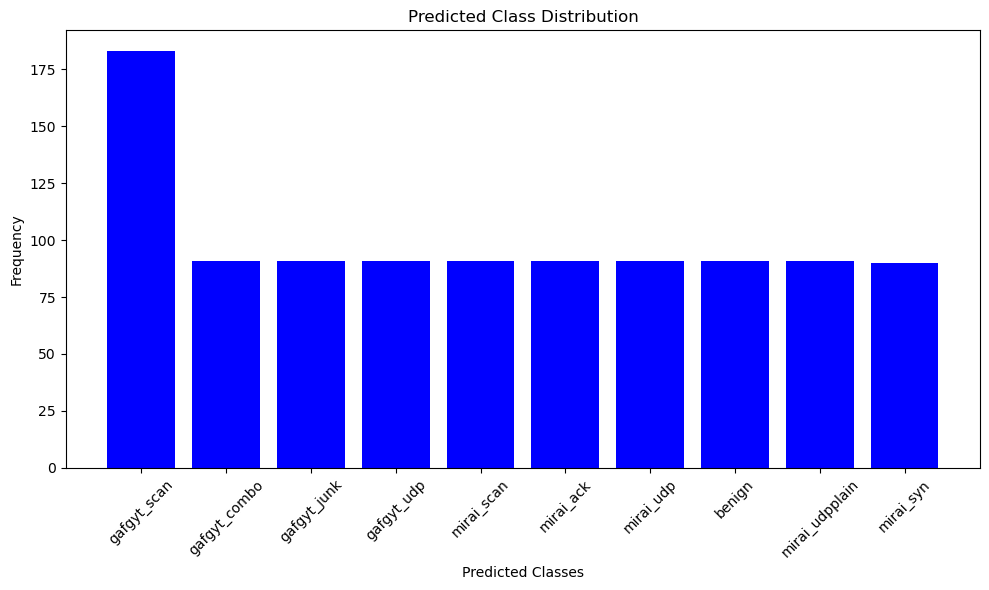

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping


class_counts = pd.Series(shuffled_predicted_class_names).value_counts()


plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color='blue')
plt.xlabel('Predicted Classes')
plt.ylabel('Frequency')
plt.title('Predicted Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()